Running PVWatts simulation...

Monthly Generation (kWh):
January: 1515.61 kWh
February: 1268.54 kWh
March: 1163.38 kWh
April: 843.62 kWh
May: 587.94 kWh
June: 493.94 kWh
July: 597.48 kWh
August: 736.76 kWh
September: 956.86 kWh
October: 1218.15 kWh
November: 1349.63 kWh
December: 1422.85 kWh

Total Annual Generation: 12154.77 kWh

PySAM Monthly AC Output (kWh) directly from Outputs.ac_monthly:
January: 1.52 kWh
February: 1.22 kWh
March: 1.16 kWh
April: 0.86 kWh
May: 0.61 kWh
June: 0.49 kWh
July: 0.57 kWh
August: 0.75 kWh
September: 0.94 kWh
October: 1.22 kWh
November: 1.33 kWh
December: 1.47 kWh
Found 4041 negative values from interpolation, setting to zero


C:\Users\PeterTunali\AppData\Local\Temp\ipykernel_19252\1333155885.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_generation = hourly_results.resample('M').sum()



Total energy (hourly): 12154.77 kWh
Total energy (half-hourly): 24343.92 kWh
Difference: 12189.15 kWh (100.2829%)

Saved half-hourly solar PV outputs to: C:\Users\PeterTunali\OneDrive - CONNELLGRIFFIN PTY LIMITED\Documents\Python\Battery_Optimisation\outputs\taggerty_pv_baseline_2024.csv
Saved parameter JSON to: C:\Users\PeterTunali\OneDrive - CONNELLGRIFFIN PTY LIMITED\Documents\Python\Battery_Optimisation\outputs\baseline_parameters.json
Saved sample day plot to: C:\Users\PeterTunali\OneDrive - CONNELLGRIFFIN PTY LIMITED\Documents\Python\Battery_Optimisation\outputs\interpolation_sample_day.png
Saved monthly generation plot to: C:\Users\PeterTunali\OneDrive - CONNELLGRIFFIN PTY LIMITED\Documents\Python\Battery_Optimisation\outputs\monthly_generation_2024.png


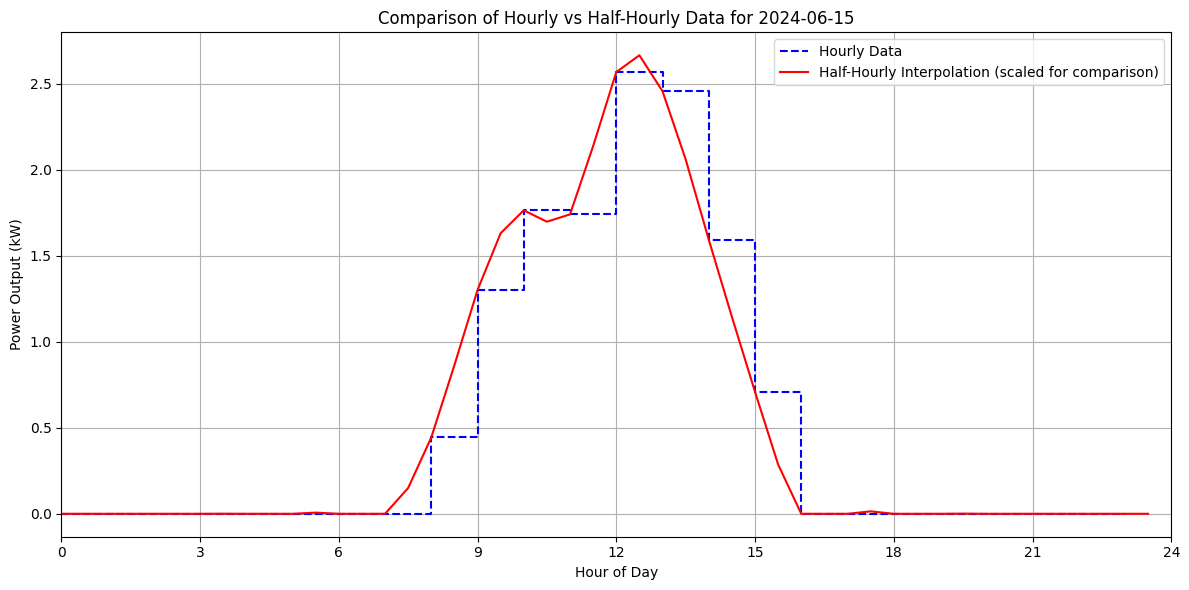

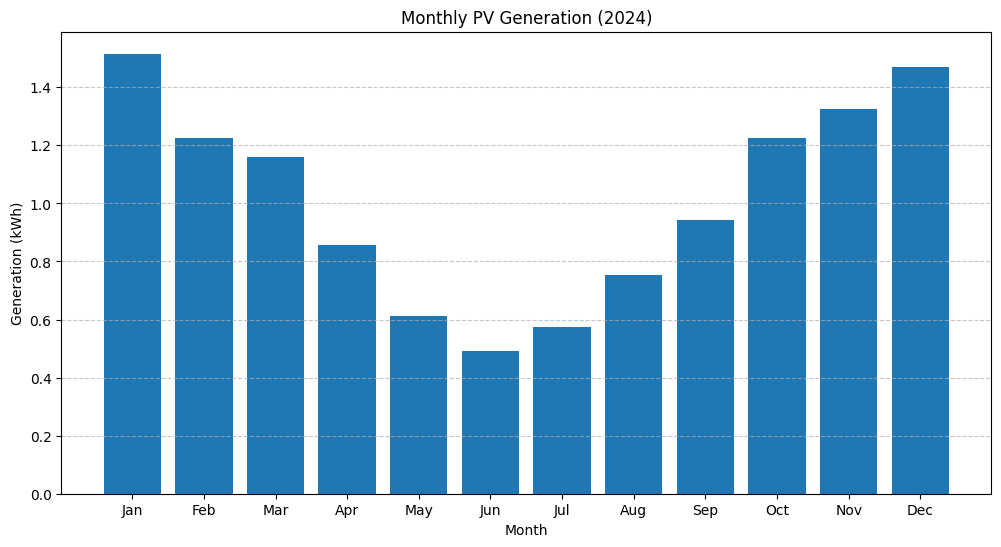

In [16]:
import PySAM.Pvwattsv8 as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import json
from scipy.interpolate import interp1d

# Define paths
project_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
weather_file_path = os.path.join(project_dir, "data", "Bonfire_2025.epw")
output_dir = os.path.join(project_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

# Create a PV system model
pv_system = pv.default("PVWattsNone")

# Set the weather file
pv_system.SolarResource.solar_resource_file = weather_file_path

# System specifications for 10 kW system
pv_system.SystemDesign.system_capacity = 10.0  # 10 kW DC
pv_system.SystemDesign.dc_ac_ratio = 1.15
pv_system.SystemDesign.inv_eff = 96
pv_system.SystemDesign.tilt = 10
pv_system.SystemDesign.azimuth = 18
pv_system.SystemDesign.module_type = 0  # Standard
pv_system.SystemDesign.array_type = 0  # Fixed (open rack)
pv_system.SystemDesign.gcr = 0.3  # Ground Coverage Ratio

# System losses (match SAM exactly)
pv_system.SystemDesign.losses = 20.28

# Run the simulation
print("Running PVWatts simulation...")
pv_system.execute()

# Get hourly AC output (in Watts) and convert to kWh
ac_output = np.array(pv_system.Outputs.ac) / 1000

# Build hourly DataFrame
start_date = datetime(2024, 1, 1, 0, 0)
hours = [start_date + timedelta(hours=i) for i in range(len(ac_output))]
hourly_results = pd.DataFrame({
    'datetime': hours,
    'ac_output_kwh': ac_output
})

# Set datetime as index
hourly_results.set_index('datetime', inplace=True)

# Get monthly AC generation (kWh)
monthly_generation = hourly_results.resample('M').sum()
print("\nMonthly Generation (kWh):")
for i, (idx, generation) in enumerate(monthly_generation.iterrows()):
    month_name = idx.strftime('%B')
    print(f"{month_name}: {generation['ac_output_kwh']:.2f} kWh")

# Get total annual generation
annual_energy_kwh = hourly_results['ac_output_kwh'].sum()
print(f"\nTotal Annual Generation: {annual_energy_kwh:.2f} kWh")

# Also get monthly AC output directly from PySAM's monthly outputs
pysam_monthly = np.array(pv_system.Outputs.ac_monthly) / 1000
print("\nPySAM Monthly AC Output (kWh) directly from Outputs.ac_monthly:")
for i, gen in enumerate(pysam_monthly):
    month_name = datetime(2024, i+1, 1).strftime('%B')
    print(f"{month_name}: {gen:.2f} kWh")

# Create half-hourly interpolation
# Reset the index for interpolation
hourly_results = hourly_results.reset_index()
# Create a reference hour of year for interpolation
hourly_results['hour_of_year'] = (hourly_results['datetime'] - start_date).dt.total_seconds() / 3600
# Create half-hour points
half_hourly_points = np.arange(0.5, 8760.5, 0.5)

# Perform cubic spline interpolation (divide hourly values by 2 to keep energy conservation)
interp_func = interp1d(hourly_results['hour_of_year'], hourly_results['ac_output_kwh'] / 2, 
                     kind='cubic', bounds_error=False, fill_value=0)
half_hourly_values = interp_func(half_hourly_points)

# Create half-hourly timestamps
half_hourly_times = [start_date + timedelta(hours=0.5*i) for i in range(len(half_hourly_points))]

# Create the half-hourly DataFrame
half_hourly_results = pd.DataFrame({
    'datetime': half_hourly_times,
    'ac_output_kwh': half_hourly_values
})

# Set any negative values to zero (can happen with cubic interpolation)
if (half_hourly_results['ac_output_kwh'] < 0).any():
    print(f"Found {(half_hourly_results['ac_output_kwh'] < 0).sum()} negative values from interpolation, setting to zero")
    half_hourly_results.loc[half_hourly_results['ac_output_kwh'] < 0, 'ac_output_kwh'] = 0

# Shift timestamps to end of interval
half_hourly_results['datetime'] = half_hourly_results['datetime'] + timedelta(minutes=30)

# Add additional columns
half_hourly_results['PV_Generation_Actual (kWh)'] = half_hourly_results['ac_output_kwh']
half_hourly_results['month'] = half_hourly_results['datetime'].dt.month
half_hourly_results['day'] = half_hourly_results['datetime'].dt.day
half_hourly_results['hour'] = half_hourly_results['datetime'].dt.hour
half_hourly_results['minute'] = half_hourly_results['datetime'].dt.minute

# Verify total energy
hourly_total = hourly_results['ac_output_kwh'].sum()
half_hourly_total = half_hourly_results['ac_output_kwh'].sum() * 2  # Multiply by 2 since we halved
print(f"\nTotal energy (hourly): {hourly_total:.2f} kWh")
print(f"Total energy (half-hourly): {half_hourly_total:.2f} kWh")
print(f"Difference: {half_hourly_total - hourly_total:.2f} kWh ({100 * (half_hourly_total - hourly_total) / hourly_total:.4f}%)")

# Save the half-hourly results to CSV
output_file = os.path.join(output_dir, "taggerty_pv_baseline_2024.csv")
half_hourly_results.to_csv(output_file, index=False)
print(f"\nSaved half-hourly solar PV outputs to: {output_file}")

# Create and save parameters JSON
params = {
    'system_capacity': 10.0,
    'dc_ac_ratio': 1.15,
    'inv_eff': 96,
    'tilt': 10,
    'azimuth': 18,
    'module_type': 0,  # Standard
    'array_type': 0,   # Fixed open rack
    'losses': 20.28,
    'gcr': 0.3,
    'output_column': 'PV_Generation_Actual (kWh)',
    'annual_generation_kwh': annual_energy_kwh,
    'monthly_generation_kwh': pysam_monthly.tolist()
}

# Save parameters to JSON
params_file = os.path.join(output_dir, "baseline_parameters.json")
with open(params_file, 'w') as f:
    json.dump(params, f, indent=4)
print(f"Saved parameter JSON to: {params_file}")

# Create and save a sample day plot
sample_day = '2024-06-15'
hourly_day = hourly_results[hourly_results['datetime'].dt.strftime('%Y-%m-%d') == sample_day].copy()
half_hourly_day = half_hourly_results[half_hourly_results['datetime'].dt.strftime('%Y-%m-%d') == sample_day].copy()

# Add hour of day columns for plotting
hourly_day['hour_of_day'] = hourly_day['datetime'].dt.hour
half_hourly_day['hour_of_day'] = half_hourly_day['datetime'].dt.hour + half_hourly_day['datetime'].dt.minute/60

plt.figure(figsize=(12, 6))
plt.step(hourly_day['hour_of_day'], hourly_day['ac_output_kwh'], where='post', 
         label='Hourly Data', color='blue', linestyle='--')
plt.plot(half_hourly_day['hour_of_day'], half_hourly_day['ac_output_kwh'] * 2, 
         label='Half-Hourly Interpolation (scaled for comparison)', color='red')

plt.xlabel('Hour of Day')
plt.ylabel('Power Output (kW)')
plt.title(f'Comparison of Hourly vs Half-Hourly Data for {sample_day}')
plt.xticks(range(0, 25, 3))  # Ticks at 0, 3, 6, 9, 12, 15, 18, 21, 24
plt.xlim(0, 24)

plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
sample_plot = os.path.join(output_dir, "interpolation_sample_day.png")
plt.savefig(sample_plot)
print(f"Saved sample day plot to: {sample_plot}")

# Also create monthly generation plot
months = range(1, 13)
plt.figure(figsize=(12, 6))
plt.bar(months, pysam_monthly)
plt.xlabel('Month')
plt.ylabel('Generation (kWh)')
plt.title('Monthly PV Generation (2024)')
plt.xticks(months, [datetime(2024, m, 1).strftime('%b') for m in months])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the monthly plot
monthly_plot = os.path.join(output_dir, "monthly_generation_2024.png")
plt.savefig(monthly_plot)
print(f"Saved monthly generation plot to: {monthly_plot}")